## Temporal Forecasting with a horizon of 1 (SVD).

## Publication:
A. Sengupta, R. Abadía-Heredia, A. Hetherington, J. Miguel Perez, S. Le Clainche - " Hybrid machine learning models based on physical patterns to accelerate CFD simulations: a short guide on autoregressive models (forthcoming on arXiV)"

**Description:**
This model presents a hybrid ROM integrating Singular Value Decomposition (SVD) with Long Short Term Memory (LSTM) architecture for temporal predictions.
Predictions are generated autoregressively, where forecasted solutions are fed back as inputs to itteratively predict the next step.
This framework is implemented using TensorFlow/Keras for 4D and 5D tensors.
This code is derived from the original work of R. Abadía-Heredia - https://github.com/mlopezm/A-predictive-hybrid-ROM-model-based-on-proper-orthogonal-decomposition-with-DL-architectures/blob/main/Cilin3D_20%20v2.1.ipynb


Operational steps:
1. Load the dataset and choose the range of snapshots to use
2. Perform SVD and choose the number of modes
3. Perform element-wise multiplication and create the train and dev(val) matrix. 80-20 split or upto the user's choice
4. Normalize the data
5. Create the sequence generator with a rolling window
6. LSTM architecture
7. Hypertunning ( Use if required or choose the parameters according to the requirement or use the values from the paper)
8. Create the model again with the best hyperparameters
9. Monitor train and val losses
10. Implement regression. Predict one, append it back to the set, and predict the next future step
11. Reconstruct

*****For a quick simulation, example weights and hyperparameters have been provided. After the section "CREATE MODEL WITH BEST PARAMETERS" directly jump to "SAVED WEIGHTS(Uncomment it)" to avoid training the model again. The example weights and hyperparameters are for the 2 DENSE architecture.*****


-Hyperparameters - bayesian_optimizationnew/lstm_hyperopthorizon 2 dense


-Saved weights (timestamp) - 20250324_194703

# INSTALL IF REQUIRED FOR COLLAB

In [ ]:
!pip install mat73
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


# IMPORT LIBRARIES

In [ ]:
import os
import sys
import time
import datetime
from datetime import datetime
import numpy as np
import pandas as pd
import collections
import scipy.io
import mat73

import matplotlib.pyplot as plt
from numpy import linalg as LA

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

#from tensorflow.keras.models import load_model # Uncomment if the example weights are being used

from keras_tuner import BayesianOptimization, HyperModel
from scipy.io import loadmat, savemat

from google.colab import drive

# LOAD DATASET AND CHOOSE RANGE  

1. User Input  
   - It will ask for file type (npy or mat) and file path.  
2. Load Tensor  
   - It uses np.load for npy files.  
   - It uses mat73.loadmat for mat files.
3. Select Temporal Range  
   - User can enter a valid range (e.g., 100-200, 1-500 etc.).

In [ ]:
#  Mount Google Drive
drive.mount('/content/drive')

#  Ask for dataset file type
file_type = input("Enter file type (.npy or .mat): ").strip()

#  Ask for dataset file path in Google Drive
file_path = input("Enter the full Google Drive path (e.g., 'MyDrive/Temporalpredictions_Standard_Sengupta/Re130_u.npy'): ").strip()
file_path = f"/content/drive/{file_path}"  # Construct full path

#  Load the dataset
if file_type == '.npy':
    tensorOrig1 = np.load(file_path)
elif file_type == '.mat':
    tensorOrig1 = mat73.loadmat(file_path)['Tensor']
else:
    raise ValueError(" Unsupported file type. Please provide a .npy or .mat file.")

#  Print Original Tensor Shape
print(f"Original Tensor shape: {tensorOrig1.shape}")

#  Get total temporal snapshots
total_slices = tensorOrig1.shape[-1]
print(f"The dataset contains {total_slices} temporal snapshots.")

#  Ask user for the range of snapshots
temporal_range = input(
    f"Enter the range of temporal snapshots to consider (e.g., '1-500', '100-200' or '300-{total_slices}'): "
).strip()

#  Validate and extract the range
try:
    start, end = map(int, temporal_range.split('-'))
    if start < 1 or end > total_slices or start > end:
        raise ValueError
except ValueError:
    raise ValueError(f" Invalid range. Please specify a valid range between 1 and {total_slices}.")

#  Slice the tensor based on the provided range
Ten_orig = tensorOrig1[..., start - 1:end]

#  Print final tensor shape
print(f"Sliced Tensor shape: {Ten_orig.shape}")

Mounted at /content/drive
Enter file type (.npy or .mat): .npy
Enter the full Google Drive path (e.g., 'MyDrive/Temporalpredictions_Standard_Sengupta/Re130_u.npy'): MyDrive/Temporalpredictions_Standard_Sengupta/Re130_u.npy
Original Tensor shape: (2, 100, 100, 500)
The dataset contains 500 temporal snapshots.
Enter the range of temporal snapshots to consider (e.g., '1-500', '100-200' or '300-500'): 1-500
Sliced Tensor shape: (2, 100, 100, 500)


# Preprocessing: Centering and Scaling Before SVD

###### Centering

- **Centering** involves subtracting the mean of each variable (or each spatial point across time) so that the data has a mean of **zero**.

Formula:
    X_centered = X - mean(X)

#### Scaling Methods

Scaling ensures that all components contribute **equally** to the decomposition by bringing them to a comparable range.  
The user can choose from the following four scaling methods:

1. **Range scaling**  

- Scales data based on the **range** (maximum - minimum) of the dataset.  
- Brings all values within a consistent range while preserving relationships.   

Formula:
    X_scaled = (X - min(X)) / (max(X) - min(X))

2. **Auto scaling (Z-score)**

- Scales data using the **standard deviation**.  
- Similar to Z-score normalization: subtracts the mean and divides by the standard deviation.  

Formula:
    X_scaled = (X - mean(X)) / std(X)

3. **Pareto scaling**

- Similar to **auto scaling**, but divides by the **square root of the standard deviation**.  
- Reduces the influence of small variations while still considering variable magnitudes.  

Formula:
    X_scaled = (X - mean(X)) / sqrt(std(X))

4. **No scaling**  
- No scaling is applied.  

In [ ]:
# Load the dataset
Ten_orig = Ten_orig.copy()  # Ensure original tensor is not modified

# Option to apply scaling before HOSVD
apply_scaling = False  # Change to True if you want scaling

# Set the scaling method: 'range', 'auto', 'pareto', 'no-scaling'
scaling_method = 'no-scaling'

if apply_scaling:
    print(f"Applying {scaling_method} scaling before HOSVD...")

    # Compute mean and standard deviation for scaling
    mean_val = np.mean(Ten_orig, axis=-1, keepdims=True)
    std_val = np.std(Ten_orig, axis=-1, keepdims=True)
    min_val, max_val = np.min(Ten_orig), np.max(Ten_orig)

    # Apply scaling based on the selected method
    if scaling_method == 'range':
        Tensor_scaled = (Ten_orig - min_val) / (max_val - min_val)  # Min-Max Scaling
    elif scaling_method == 'auto':
        Tensor_scaled = (Ten_orig - mean_val) / std_val  # Standard Z-score Scaling
    elif scaling_method == 'pareto':
        Tensor_scaled = (Ten_orig - mean_val) / np.sqrt(std_val)  # Pareto Scaling
    elif scaling_method == 'no-scaling':
        Tensor_scaled = Ten_orig  # No scaling (keeps original values)
    else:
        raise ValueError(f"Invalid scaling method: {scaling_method}")

    # Update tensorOrig to use the scaled version
    tensorOrig = Tensor_scaled
    print("Scaling applied.")
else:
    print("No scaling applied. Proceeding with original tensor.")

No scaling applied. Proceeding with original tensor.


# Shape the matrix in order to recover the original tensor

In [ ]:
Mat_orig = np.reshape(np.copy(Ten_orig), [np.prod(Ten_orig.shape[:-1]), Ten_orig.shape[-1]], order = 'F')
Mat_orig.shape

(20000, 500)

# APPLY SVD & CHOOSE THE MODES

1. Decompose by applying SVD
2. Input the required number of modes

In [ ]:
U, S, V = np.linalg.svd(Mat_orig, full_matrices=False)

Modes = 10 # Choose the required number of modes

S = np.diag(S)

U = U[:,0:Modes]
S = S[0:Modes,0:Modes]
V = V[0:Modes,:]

In [ ]:
U.shape

(20000, 10)

# AML TRAIN AND DEV ( Create train and dev(val))
1. Create AML matrix using S,V from SVD
2. Implement the 80-20 split (80% for training and 20% for dev/val and test) or according to choice

In [ ]:
AML = np.dot(S,V)
tensor = AML
AML_train = AML[:, :400] # 80-20 split
# Select next 100 snapshots for dev/val. The same will be used for test
AML_dev = AML[:, 400:500]

print(f"AML Train Set Shape: {AML_train.shape}")
print(f"AML Development Set Shape: {AML_dev.shape}")

AML Train Set Shape: (10, 400)
AML Development Set Shape: (10, 100)


In [ ]:
tensor = np.concatenate([np.copy(AML_train), np.copy(AML_dev)], axis = 1)
tensor_test = np.copy(AML_dev)

# DATASET CONFIGURATION AND SCALING/NORMALIZATION

1. **Compute Statistics**  
   - Calculate the mean and standard deviation of the tensor.    
2. **Apply Z-Score Normalization**  
   - It centers the data by subtracting the mean and dividing by the standard deviation.
   
Z-score normalization ensures that the data has a mean of zero and a standard deviation of one, which helps stabilize training, prevents certain features from dominating, and improves the convergence.

In [ ]:
apply_scaling_after_AML = True  # Change to True if you want to apply normalization

# Set the scaling method: 'range', 'auto', 'pareto', 'no-scaling'
decision_after_AML = 'auto'

if apply_scaling_after_AML:
    print(f"Applying {decision_after_AML} scaling after AML construction...")

    # Compute global mean and standard deviation
    mean_val = np.mean(tensor)
    std_val = np.std(tensor)

    print("Mean:", mean_val)
    print("Standard Deviation:", std_val)

    # Compute quantiles (optional, for reference)
    quantiles = np.quantile(tensor.flatten(), np.arange(0, 1, 0.1))
    print("Quantiles:", quantiles)

    # Apply scaling based on the selected method
    if decision_after_AML == 'range':
        min_val, max_val = np.min(tensor), np.max(tensor)
        tensor_norm = (tensor - min_val) / (max_val - min_val)  # Min-Max Scaling
        tensor_test_norm = (tensor_test - min_val) / (max_val - min_val)
    elif decision_after_AML == 'auto':
        tensor_norm = (tensor - mean_val) / std_val  # Standard Scaling (Z-score)
        tensor_test_norm = (tensor_test - mean_val) / std_val
    elif decision_after_AML == 'pareto':
        pareto_factor = np.sqrt(std_val)
        tensor_norm = (tensor - mean_val) / pareto_factor  # Pareto Scaling
        tensor_test_norm = (tensor_test - mean_val) / pareto_factor
    elif decision_after_AML == 'no-scaling':
        tensor_norm, tensor_test_norm = tensor, tensor_test  # No changes

    tensor_train_norm = tensor_norm
    tensor_val_norm = tensor_test_norm

    # Compute statistical summary
    stats_after_AML = scipy.stats.describe(tensor_norm.flatten())
    print("Statistical Summary After AML Scaling:", stats_after_AML)

else:
    print("No scaling applied after AML construction. Proceeding with original tensor.")

# Set dimensions for further processing
total_length = tensor.shape[1]
channels_n = 0
dim_x = tensor.shape[0]
dim_y = 0

# Print dimensions
print('total_length: ', total_length)
print('channels_n: ', channels_n)
print('dim_x: ', dim_x)
print('dim_y: ', dim_y)

Applying auto scaling after AML construction...
Mean: -9.85549001325524
Standard Deviation: 29.92312182504453
Quantiles: [-98.56224365 -22.8040576   -1.97172601  -1.18515687  -0.35393023
  -0.12195449   0.1209984    0.35888397   1.19009679   1.96834357]
Statistical Summary After AML Scaling: DescribeResult(nobs=5000, minmax=(np.float64(-2.9644886038059703), np.float64(0.8118526784594049)), mean=np.float64(-1.1368683772161603e-16), variance=np.float64(1.0002000400080013), skewness=np.float64(-2.5490563432136955), kurtosis=np.float64(4.750717846091787))
total_length:  500
channels_n:  0
dim_x:  10
dim_y:  0


In [ ]:
def reverse_scaling(tensor_scaled, mean_val=None, std_val=None, min_val=None, max_val=None, scaling_method="auto"):

    if scaling_method == "range":
        # Reverse Min-Max Scaling
        return tensor_scaled * (max_val - min_val) + min_val

    elif scaling_method == "auto":
        # Reverse Z-score Normalization
        return tensor_scaled * std_val + mean_val

    elif scaling_method == "pareto":
        # Reverse Pareto Scaling
        return tensor_scaled * np.sqrt(std_val) + mean_val

    elif scaling_method == "no-scaling":
        # No change in the data
        return tensor_scaled

    else:
        raise ValueError(f"Invalid scaling method: {scaling_method}. Choose from 'range', 'auto', 'pareto', or 'no-scaling'.")


# SEQUENCE GENERATOR

1. **Take Data**  
   - Use the given data, sequence length, batch size, and horizon.  
2. **Split Data into Small Batches**  
   - Break the data into smaller parts to process efficiently.  
3. **Pick the Data for Each Batch**  
   - Select the slices of data for input and output.  
4. **Shuffle the Data if Needed**    
5. **Rolling Window**  
   - Move step by step through the data, using the past values to predict future ones.
- **Batch Size**: The samples that are used at a time for training.  
- **Sequence Length**: The past data used to make predictions.  
- **Horizon**: The future steps the model is predicting.   

In [ ]:
class SequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, list_IDs, batch_size=5, seq_len=624, horizon=1, shuffle=True, till_end=False, only_test=False):
        self.data = data
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.horizon = horizon
        self.till_end = till_end
        self.only_test = only_test
        self.on_epoch_end()

    def __len__(self):
        """
        Computes the number of batches per epoch.
        """
        if self.till_end:
            return math.ceil(len(self.list_IDs) / self.batch_size)
        else:
            return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates one batch of data.
        """
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)

        # Ensure y is returned in a structured format TensorFlow expects
        if self.only_test:
            return X
        else:
            return X, np.stack(y, axis=1)  # (batch_size, horizon, velocity_components)

    def on_epoch_end(self):
        """
        Updates indexes after each epoch and shuffles if necessary.
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        """
        Generates data containing batch_size samples.

        Returns:
        - X: Input data with shape (batch_size, seq_len, features)
        - y: Target data with shape (batch_size, horizon, features)
        """
        num_features = self.data.shape[0]

        # Initialize empty arrays
        X = np.empty((self.batch_size, self.seq_len, num_features))
        y_inter = np.empty((self.batch_size, self.horizon, num_features))

        # Populate the input and target tensors
        for i, ID in enumerate(list_IDs_temp):
            X[i, :, :] = self.data[:, ID:ID + self.seq_len].T
            y_inter[i, :, :] = self.data[:, ID + self.seq_len:ID + self.seq_len + self.horizon].T

        # Standard case: Sequential horizon prediction (stacked along the second axis)
        y = [y_inter[:, h, :] for h in range(self.horizon)]

        # Ensure y is structured as a proper NumPy array
        y = np.stack(y, axis=1)

        return X, y


# LSTM Architecture

1. **Take the Input Data**  
   - The model takes the input - in_shape(seq_len, modes or dim_x).  
2. **Process the  Data with LSTM**  
   - Used an LSTM (Long Short-Term Memory) layer with 128 units to learn patterns over time.  
3. **Pass the Data Through a Dense Layer**  
   - It converts LSTM output into the required prediction size (out_dim).  
4. **Compile the Model**  
   - Used mean squared error (MSE) as the loss function.  
   - Optimized with the Adam optimizer.  
   - Tracked mean absolute error (MAE) for evaluation.  

- **LSTM**:  LSTMs
are a type of recurrent neural network (RNN) designed to capture long-term dependencie
in sequential data.  
- **Dense Layer**: A dense layer, also known as a fully connected layer, performs a linear operation on the input data, applying weights and biases, followed by an activation function, which introduces non-linearity.    
- **Optimizer (Adam)**: Adjusts weights to improve model accuracy.

In [ ]:
def create_model(in_shape, out_dim, horizon=1, shared_dim=128, learning_rate=0.001, architecture='2dense'):
    x = Input(shape=in_shape)

    # LSTM layer
    v = LSTM(128, return_sequences=False)(x)

    if architecture == '2dense':
        w = Dense(64, activation=LeakyReLU(alpha=0.01))(v)
        v = Dense(out_dim, activation='linear')(w)
    elif architecture == '1dense':
        v = Dense(out_dim, activation='linear')(v)
    else:
        raise ValueError(f"Unknown architecture type: {architecture}")

    model = Model(inputs=x, outputs=v, name='Temporal_forecasting')
    model.compile(
        loss='mean_squared_error',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['mae']
    )

    return model


########ADDED HYPERTUNNING TO BE USED IF REQUIRED. FROM THE PAPER, THE VALUES FROM HOSVD WERE USED TO MAINTAIN SIMILARITY########

# BAYESIAN OPTIMIZATION FOR HYPERPARAMETER TUNING

1. **Define the  Search Space**  
   - Tuned the seq_len, batch_size, and learning_rate.  
   - Choose ranges according to the case.   
2. **Set Up Bayesian Optimization**  
   - Choose appropiate number of epochs and trials.  
3. **Run Optimization and Find the Best Parameters**  
   - Train the model with different hyperparameter settings.  
   - It returns the best combination for training.

Bayesian optimization efficiently finds the best hyperparameters by intelligently selecting values instead of random searching. It helps reduce training time and improves model performance.  

### Other Common Hyperparameter Tuning Methods ###
- **Grid Search**  
- **Random Search**  
- **Genetic Algorithms**  

In [ ]:
class LSTMHyperModel(HyperModel):
    """
    Custom HyperModel class for LSTM tuning with SequenceGenerator.
    """

    def __init__(self, tensor_norm, AML_train, AML_dev, dim_x):
        self.tensor_norm = tensor_norm
        self.AML_train = AML_train
        self.AML_dev = AML_dev
        self.dim_x = dim_x

    def build(self, hp):
        """
        Defines the model architecture with tunable hyperparameters.
        """
        seq_len = hp.Int('seq_len', min_value=5, max_value=20, step=5)
        batch_size = hp.Int('batch_size', min_value=4, max_value=32, step=4)
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='log')

        in_shape = (seq_len, self.dim_x)
        out_dim = self.dim_x
        model = create_model(in_shape, out_dim, horizon=1, shared_dim=128, learning_rate=learning_rate)

        return model

    def fit(self, hp, model, *args, **kwargs):
        """
        Creates the SequenceGenerator dynamically and fits the model.
        """
        seq_len = hp.get('seq_len')
        batch_size = hp.get('batch_size')

        #  Create SequenceGenerators with optimized hyperparameters
        train_gen = SequenceGenerator(
            self.tensor_norm, np.arange(self.AML_train.shape[1]),
            batch_size=batch_size, seq_len=seq_len, horizon=1, shuffle=True
        )
        val_gen = SequenceGenerator(
            self.tensor_norm, np.arange(self.AML_dev.shape[1]),
            batch_size=batch_size, seq_len=seq_len, horizon=1, shuffle=False
        )

        return model.fit(train_gen, validation_data=val_gen, epochs=10)

#  Define the function to run Bayesian Optimization
def run_bayesian_optimization(tensor_norm, tensor_test_norm, AML_dev, AML_train, dim_x):
    """
    Runs Bayesian Optimization for hyperparameter tuning.
    """
    print(" Initializing Bayesian Optimization...")

    hypermodel = LSTMHyperModel(tensor_norm, AML_train, AML_dev, dim_x)

    tuner = BayesianOptimization(
        hypermodel,
        objective='val_loss',
        max_trials=30,
        directory='/content/drive/MyDrive/Temporalpredictions_Standard_Sengupta/bayesian_optimizationnew',
        project_name='lstm_hyperopthorizon 2 dense',
        overwrite=False
    )

    print(" Starting Bayesian Optimization...")

    #  Now correctly pass datasets
    tuner.search(epochs=10)

    print(" Tuning completed successfully.")

    #  Get Best Hyperparameters
    try:
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    except Exception as e:
        print(f" Error getting best hyperparameters: {e}")
        return None

    print(f" Best Hyperparameters Found: seq_len={best_hps.get('seq_len')}, batch_size={best_hps.get('batch_size')}, learning_rate={best_hps.get('learning_rate')}")

    return best_hps

#  Run Bayesian Optimization
best_hps = run_bayesian_optimization(tensor_norm, tensor_test_norm, AML_dev, AML_train, dim_x)


 Initializing Bayesian Optimization...
Reloading Tuner from /content/drive/MyDrive/Temporalpredictions_Standard_Sengupta/bayesian_optimizationnew/lstm_hyperopthorizon 2 dense/tuner0.json
 Starting Bayesian Optimization...
 Tuning completed successfully.
 Best Hyperparameters Found: seq_len=20, batch_size=4, learning_rate=0.001


# CREATE NEW GENERATORS (with the new parametrs)

In [ ]:
# Get test, val, and train lengths
test_length = AML_dev.shape[-1]
val_length  = AML_dev.shape[1]
train_length = AML_train.shape[1]
best_seq_len = best_hps.get('seq_len')
best_batch_size = best_hps.get('batch_size')

train_generator = SequenceGenerator(
    tensor_norm, np.arange(AML_train.shape[1]),
    batch_size=best_batch_size,seq_len=best_seq_len, horizon=1, shuffle=True
)

validation_generator = SequenceGenerator(
    tensor_norm, np.arange(AML_dev.shape[1]),
    batch_size=best_batch_size, seq_len=best_seq_len, horizon=1, shuffle=False
)

test_generator = SequenceGenerator(
    tensor_test_norm, np.arange(tensor_test_norm.shape[1]),
    batch_size=best_batch_size, seq_len=best_seq_len, horizon=1, only_test=True, shuffle=False
)

for batch in validation_generator:
    input_nn, target_nn = batch
    break

print(len(input_nn))
print(input_nn[0].shape)
print(len(target_nn))
print(target_nn[0].shape)

4
(20, 10)
1
(4, 10)


# CREATE MODEL WITH BEST HPs
Training on a CPU takes time. Use the example weights mentioned in the description for a quick result

In [ ]:
# Create and summarize the model
model = create_model(in_shape=(best_seq_len, dim_x), out_dim=dim_x, horizon=1, learning_rate=best_hps.get('learning_rate'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Temporal_forecasting"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 20, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │          71,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,074 (312.79 KB)

 Trainable params: 80,074 (312.79 KB)

 Non-trainable params: 0 (0.00 B)

# SAVE THE WEIGHTS

In [ ]:
# Timestamped experiment folder to avoid overwriting
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
experiment_dir = f'/content/drive/MyDrive/Temporalpredictions_Standard_Sengupta/run_{timestamp}'
os.makedirs(experiment_dir, exist_ok=True)

# Print the directory so to reference it later
print(f"Experiment results will be saved in: {experiment_dir}")

# Save file paths
save_best_weights = os.path.join(experiment_dir, 'best_model.keras')
save_last_weights = os.path.join(experiment_dir, 'last_model.keras')
save_summary_stats = os.path.join(experiment_dir, 'training_history.csv')
save_results_metrics = os.path.join(experiment_dir, 'results_metrics.csv')


Experiment results will be saved in: /content/drive/MyDrive/Temporalpredictions_Standard_Sengupta/run_20250324_194703


# TRAINING
1. **Used Callbacks**  
   - **ModelCheckpoint**: Save the best model based on validation loss.  
   - **EarlyStopping**: It stops training if validation loss doesn’t improve for a fixed number of  epochs (10).  
2. **Train the Model**  
   - Run for a selected number of epochs while monitoring performance (validation loss).   

**Callbacks**: Automated functions that adjust training behavior (e.g., saving models, stopping early).  
**Patience**: It defines how many epochs the training continues without improvement before stopping.

In [ ]:
np.random.seed(247531338)
tf.random.set_seed(31722973)


callbacks = [
    ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True, mode='auto'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
]

num_epochs = 500
history = model.fit(train_generator, validation_data=validation_generator, epochs=num_epochs, verbose=1, callbacks=callbacks)


Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.2184 - mae: 0.2309 - val_loss: 0.0234 - val_mae: 0.0900
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0226 - mae: 0.0848 - val_loss: 0.0168 - val_mae: 0.0756
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0157 - mae: 0.0763 - val_loss: 0.0066 - val_mae: 0.0579
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0039 - mae: 0.0465 - val_loss: 8.6288e-04 - val_mae: 0.0208
Epoch 5/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.8163e-04 - mae: 0.0209 - val_loss: 7.6799e-04 - val_mae: 0.0189
Epoch 6/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.0645e-04 - mae: 0.0200 - val_loss: 6.8969e-04 - val_mae: 0.0189
Epoch 7/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 7.8051e-04 - mae: 0.0200 - val_loss: 6.3560e-04 - val_mae: 0.0178
Epoch 8/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 6.8319e-04 - mae: 0.0187 - val_loss: 8.0082e-04 - val_mae: 0.0212
Epoc

In [ ]:
# Save last model manually
model.save(save_best_weights)

# Save training history
pd.DataFrame(history.history).to_csv(save_summary_stats, index=False)

# TRAIN & VAL LOSS MONITORING

In [ ]:
# Aggregate the summary statistics
summary_stats = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                              'train_loss': history.history['loss'],
                              'val_loss': history.history['val_loss']})

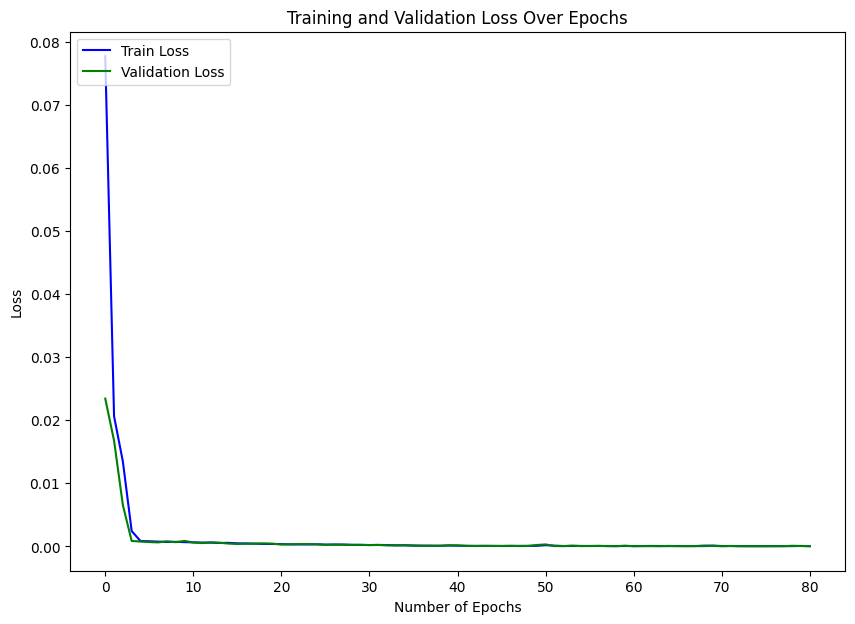

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(summary_stats.train_loss, 'b', label='Train Loss')
ax.plot(summary_stats.val_loss, 'g', label='Validation Loss')
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss Over Epochs')
ax.legend(loc='upper left')

plt.show()

#SAVED WEIGHTS ( Uncomment to use the example weights)

In [ ]:
# # Replace this with your actual timestamped folder
# timestamp = '20250324_194703'
# experiment_dir = f'/content/drive/MyDrive/Temporalpredictions_Standard_Sengupta/run_{timestamp}'

# # Define saved paths
# save_best_weights = os.path.join(experiment_dir, 'best_model.keras')
# save_summary_stats = os.path.join(experiment_dir, 'training_history.csv')

# # Load the best saved model
# model = load_model(save_best_weights, custom_objects={'LeakyReLU': LeakyReLU})
# print(" Model loaded successfully!")


✅ Model loaded successfully!


# REGRESSION
1. **Prepare Data**  
   - Copy the input tensor and extract the last inputWidth (best sequence length) time steps as the starting point.  
   - Transposed the data to match the expected model input shape.  
2. **Iterative Prediction**  
   - Predict the time_pred future steps one by one.  
   - Each new prediction is added back as input for the next step.  
3. **Inverse Transformation**  
   - Convert the predictions back to original scale using mean and standard deviation.  
4. **Select Targets for Comparison**  
   - User can select a starting index for ground truth targets.   


In [ ]:
def evaluate_model_test_iter(ten_orig_1, time_pred, inputWidth, mean_val, std_val, min_val, max_val, scaling_method):

    ten_orig = np.copy(ten_orig_1)

    output_shape = (ten_orig.shape[0], time_pred)

    # For 5D tensors
    if len(ten_orig.shape) == 5:
        output_shape = (ten_orig.shape[0], time_pred)

    predictions = np.empty(output_shape)

    snap = np.copy(ten_orig[..., -inputWidth:])
    snap = np.transpose(snap, [1, 0])
    snap = snap[None, ...]
    print(f"Input snapshot shape: {snap.shape}")

    # Iteratively predict the next time steps
    for i in range(time_pred):
        pred = model.predict(snap, verbose=0)
        pred = np.array(pred)

        if len(pred.shape) == 2:
            pred = pred[:, None, :]

        pred = np.transpose(pred, [1, 0, 2])

        # Apply inverse transformation using generalized scaling
        pred_1 = reverse_scaling(pred[0, :, :], mean_val, std_val, min_val, max_val, scaling_method)

        predictions[..., i] = pred_1

        # Concatenate the new prediction with the previous input
        snap = np.concatenate([snap[:, 1:, :], pred], axis=1)

    del ten_orig, snap, pred, pred_1

    return predictions

# CHOOSE TARGETS
- User can select a starting index for ground truth targets.
- Generate the predictions

In [ ]:
########### Choose the starting point of the targets ###########
t0 = time.time()

time_pred = 100  # Number of time steps to predict
inputWidth = best_hps['seq_len']
scaling_method = "auto"
min_val, max_val = np.min(tensor), np.max(tensor)
mean_val, std_val = np.mean(tensor), np.std(tensor)

# Call the function with all required arguments
predictions = evaluate_model_test_iter(
    tensor_norm[:, :-100],
    time_pred=time_pred,
    inputWidth=inputWidth,
    mean_val=mean_val,
    std_val=std_val,
    min_val=min_val,
    max_val=max_val,
    scaling_method=scaling_method
)


target_start = int(input("Enter the starting index for targets (e.g., 400, 450 etc.): ").strip())

if len(Ten_orig.shape) == 4:
    targets = Ten_orig[:, :, :, target_start:target_start + time_pred]
elif len(Ten_orig.shape) == 5:
    targets = Ten_orig[:, :, :, :, target_start:target_start + time_pred]

t1 = time.time()

# Print results
print(f"Time taken: {t1 - t0} seconds")
print(f"Predictions shape: {predictions.shape}")

Input snapshot shape: (1, 20, 10)
Enter the starting index for targets (e.g., 400, 450 etc.): 400
Time taken: 14.563658714294434 seconds
Predictions shape: (10, 100)


# RECONSTRUCTION
1. Reconstruct using U and predictions
2. Reshape to match the original shape

In [ ]:
A_d_flat = np.dot(U, predictions)
if tensorOrig1.ndim == 4:  # Case for 4D tensor
    original_shape = (tensorOrig1.shape[0], tensorOrig1.shape[1], tensorOrig1.shape[2], time_pred)
elif tensorOrig1.ndim == 5:  # Case for 5D tensor
    original_shape = (tensorOrig1.shape[0], tensorOrig1.shape[1], tensorOrig1.shape[2], tensorOrig1.shape[3],  time_pred)
else:
    raise ValueError("Unsupported tensor dimensionality. Expected 4D or 5D tensor.")

A_d = np.reshape(A_d_flat, original_shape, order='F')
print(f"Reconstructed tensor shape: {A_d.shape}")

Reconstructed tensor shape: (2, 100, 100, 100)


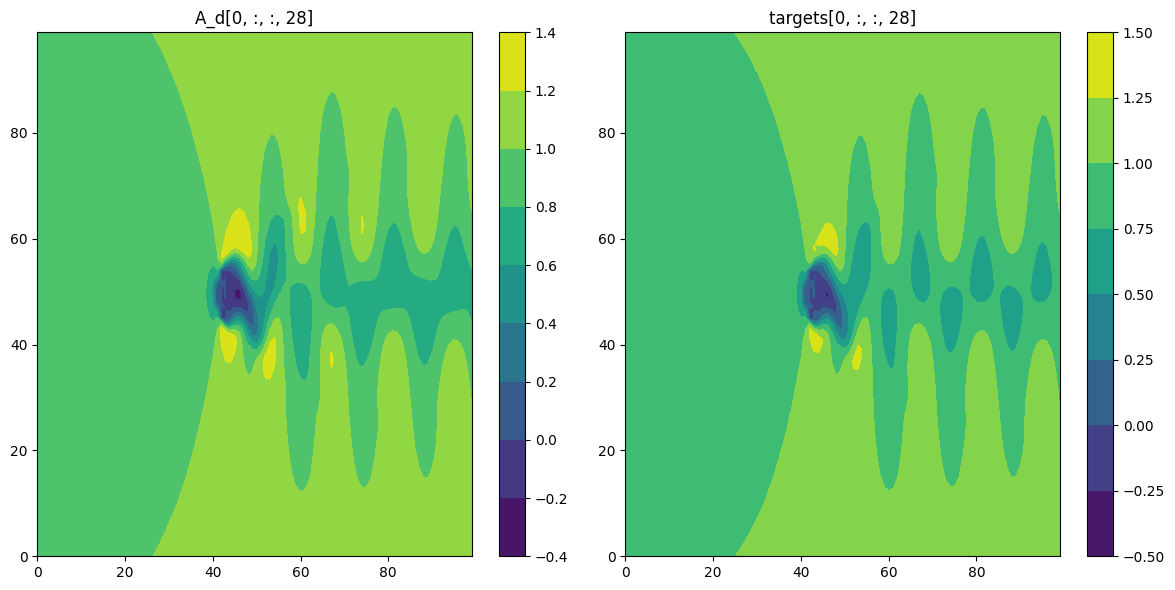

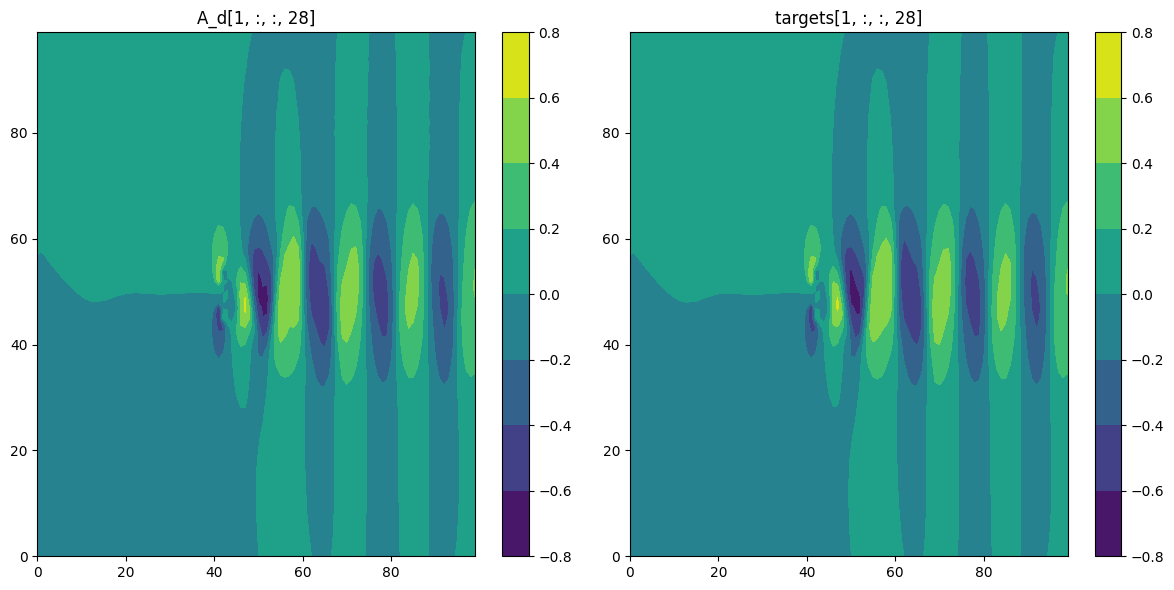

In [ ]:
def plot_tensors(A_d, targets, velocity_components, time_index):
    if A_d.ndim not in [4, 5] or targets.ndim not in [4, 5]:
        raise ValueError("Input tensors must be 4D or 5D.")
    if A_d.shape != targets.shape:
        raise ValueError("Shape of A_d and targets must match.")

    for comp in range(velocity_components):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        contour_pred = axs[0].contourf(
            A_d[comp, :, :, 0, time_index] if A_d.ndim == 5 else A_d[comp, :, :, time_index],
            cmap='viridis'
        )
        axs[0].set_title(f'A_d[{comp}, :, :, 0, {time_index}]' if A_d.ndim == 5 else f'A_d[{comp}, :, :, {time_index}]')
        fig.colorbar(contour_pred, ax=axs[0], orientation='vertical')

        contour_target = axs[1].contourf(
            targets[comp, :, :, 0, time_index] if targets.ndim == 5 else targets[comp, :, :, time_index],
            cmap='viridis'
        )
        axs[1].set_title(f'targets[{comp}, :, :, 0, {time_index}]' if targets.ndim == 5 else f'targets[{comp}, :, :, {time_index}]')
        fig.colorbar(contour_target, ax=axs[1], orientation='vertical')
        plt.tight_layout()
        plt.show()

time_index = 28
velocity_components = 2
plot_tensors(A_d, targets, velocity_components, time_index)
